Note: this notebook is written to work in Colab, and thus it installs the `eigenlearning` repo from Github. If the repo is already present on the system, the install cell can be skipped and the modules imported directly, and the saving to Drive can be replaced with saving locally.

Another note: we assembled these notebooks out of modular parts from other notebooks, and thus we have not run all of them. If something doesn't work, let us know and we'll be glad to know and happy to fix it.

# Imports and installs

In [ ]:
!pip install -q git+https://www.github.com/google/neural-tangents

import os
import sys

if os.path.isdir('/content/eigenlearning'):
  !rm -r '/content/eigenlearning'
!git clone -q https://github.com/james-simon/eigenlearning.git
sys.path.insert(0,'/content/eigenlearning')

     |████████████████████████████████| 92 kB 734 kB/s 


In [ ]:
import json
import math

import jax
from jax import grad
import jax.numpy as np
import jax.random as random

import matplotlib.gridspec as gridspec
from matplotlib.colors import hsv_to_rgb
import matplotlib.pyplot as plt

import numpy as basenp

In [ ]:
from utils import get_net_fns, net_predictions, kernel_predictions, mse
from measures import learning_measure_predictions, learning_measure_statistics, find_C
from unit_circle import unit_circle_eigenvalues, get_unit_circle_dataset
from hypercube import hypercube_eigenvalues, get_hypercube_dataset
from hypersphere import hypersphere_eigenvalues, get_hypersphere_dataset, hyp_har_multiplicity
from image_datasets import get_image_dataset

/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Run experiment and save data

In [ ]:
main_dir = '/content/drive/DIRECTORY/conservation_of_lrn'

In [ ]:
for dir in [main_dir, main_dir+'/circle']:
  if not os.path.exists(dir):
      os.makedirs(dir)

In [ ]:
net_fn_sets = []
net_fn_sets += [get_net_fns(width=500, d_out=1, n_hidden_layers=1)]
net_fn_sets += [get_net_fns(width=500, d_out=1, n_hidden_layers=4)]
net_fn_sets += [get_net_fns(width=500, d_out=1, n_hidden_layers=1, phi=np.tanh, W_std=1.5, b_std=.1)]
net_fn_sets += [get_net_fns(width=500, d_out=1, n_hidden_layers=4, phi=np.tanh, W_std=1.5, b_std=.1)]

In [ ]:
M = 10
ns_exp = [3, 6]
modes = [(k,'c') for k in range(M//2 + 1)] + [(k,'s') for k in range(1, (M+1)//2)]
print(modes)

[(0, 'c'), (1, 'c'), (2, 'c'), (3, 'c'), (4, 'c'), (5, 'c'), (1, 's'), (2, 's'), (3, 's'), (4, 's')]


In [ ]:
exp_params = {
    'domain': 'circle',
    'M': M,
    'n': None,
    'f_terms': None,
    'g_terms': [],
    'n_epochs': 10000,
    'lr': .5,
    'stop_mse': 10**-5,
    'print_every': None,
    'n_trials': 1,
    'seed': 1,
    'pred_type': 'both'
}

In [ ]:
results_exp = {}

for a, net_fns in enumerate(net_fn_sets):
  for n in ns_exp:
    print(f'testing (a={a}, n={n})')
    exp_params['n'] = n

    for mode in modes:
      exp_params['f_terms'] = {mode : 1}
      results_exp[str(a)+','+str(n)+','+str(mode[0])+','+str(mode[1])] = learning_measure_statistics(net_fns, **exp_params)
    
    with open(main_dir+'/circle/results_exp.json', 'w') as file:
      json.dump(results_exp, file)
  print()

# Load data and make figure

In [ ]:
results = {'circle': {'exp' : {}}}

with open(main_dir + '/circle/results_exp.json', 'r') as file:
  results['circle']['exp'] = json.load(file)

##### Convert results from string keys to tuple keys

In [ ]:
keys = list(results['circle']['exp'].keys())
for key in keys:
  if isinstance(key, str):
    a, n, k, m = [int(x) if x.isdigit() else x for x in key.split(',')]
    results['circle']['exp'][(a, n, k, m)] = results['circle']['exp'][key]
    del results['circle']['exp'][key]

##### Extract some metadata

In [ ]:
metadata = {'as':set(), 'ns':set(), 'modes':set()}

for a, n, k, m in results['circle']['exp'].keys():
  metadata['as'].add(a)
  metadata['ns'].add(n)
  metadata['modes'].add((k,m))

for key in metadata:
  metadata[key] = sorted(list(metadata[key]))

Make plots

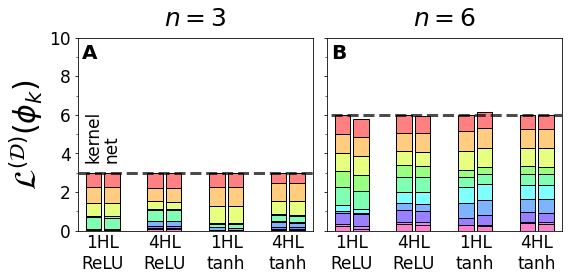

In [ ]:
ns = metadata['ns']
archs = np.array(metadata['as'])
modes = list(reversed(metadata['modes']))

colors_ker = [hsv_to_rgb((1 - (i+1)/len(modes),.5,1)) for i in range(len(modes))]
colors_net = [hsv_to_rgb((1 - (i+1)/len(modes),.5,1)) for i in range(len(modes))]

fig, axs = plt.subplots(nrows=1, ncols=len(ns), figsize=(8,4))

A, B = 4, 1.2

for i, n in enumerate(ns):
  ax = axs[i]

  total_lrns_k = np.zeros_like(archs)
  total_lrns_n = np.zeros_like(archs)

  for j, (k, m) in enumerate(modes):
    mode_lrns_k = np.array([results['circle']['exp'][a,n,k,m]['kernel']['lrn'][0] for a in archs])
    mode_lrns_n = np.array([results['circle']['exp'][a,n,k,m]['net']['lrn'][0] for a in archs])

    ax.bar(A*archs, mode_lrns_k, width=1, bottom=total_lrns_k, color=colors_ker[j], edgecolor=(0,0,0), label='kernel' if j==len(modes)-1 else None)
    ax.bar(A*archs + B, mode_lrns_n, width=1, bottom=total_lrns_n, color=colors_net[j], edgecolor=(0,0,0), label='net' if j==len(modes)-1 else None)

    total_lrns_k += mode_lrns_k
    total_lrns_n += mode_lrns_n

  ax.plot([-10,100], [n,n], color=(0,0,0,.7), linestyle='--', lw=3)
  ax.set_xlim(-1, A*(len(archs)-1)+B+1)
  ax.set_ylim((0, 10))

  xtick_xs = []
  xtick_labels = []
  for a in archs:
    net_name = ['1HL\nReLU', '4HL\nReLU', '1HL\ntanh', '4HL\ntanh'][a]
    xtick_xs += [a*A + B/2]
    xtick_labels += [net_name]
  ax.set_xticks(xtick_xs)
  ax.set_xticklabels(xtick_labels, fontsize=17)
  ax.set_yticks(range(0,11,2), minor=False)
  ax.set_yticks(range(1,10,2), minor=True)

  ax.tick_params(axis='x', which='major', length=0)
  ax.tick_params(axis='y', which='major', labelsize=17)

  if i > 0:
    ax.set_yticklabels([])
  if i == 0:
    ax.set_ylabel(r'$\mathcal{L}^{(\mathcal{D})}(\phi_k)$', fontsize=30)

  ax.set_title(f'$n={n}$', fontsize=25, y=1.03)

  if i == 0:
    ax.text(0, 3.5, 'kernel', va='bottom', ha='center', rotation=90, fontsize=17)
    ax.text(B, 3.5, 'net', va='bottom', ha='center', rotation=90, fontsize=17)

  ax.text(.05, .89, 'AB'[i], transform=ax.transAxes, size=20, weight='bold', ha='center')

fig.tight_layout()

plt.savefig('conservation_of_lrn.pdf')